# Transformers

In this notebook we will be walking through a simple example using the energax transformer implementation. This demo notebook will not contain EBM usage explicitly, but just goes through the transformer architecture as it forms the backbone of many modern techniques. We will try to stay pretty similar to the original transformer (https://arxiv.org/abs/1706.03762).

In [1]:
# from tqdm.notebook import tqdm
from energax.nns import Transformer
import jax
from jax import numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
import optax

First we need to make a simple dataset. Although we could use common NLP datasets, these are much larger and take much longer to train (e.g. hours even on a good GPU), so for the sake of pedagogy we work with a simpler example. This example is inspired by (https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial6/Transformers_and_MHAttention.html). The goal of the encoder-decoder based transformer is sequence to sequence prediction (e.g. translation). In this case, we will simply be reversing a set of input tokens. Note that this is a problem in which transformers will shine over something like RNNs since transformers can attend across the whole of the input length.

The dataset consists of various length-ed arrays of integers/tokens. There is a maximum length and a maximum token value, but just like with NLP tasks, not every input is the same length (in NLP not every sentence is the same number of tokens). To work with these ragged arrays in an efficient manner in jax, we simply pad out them out (not an uncommon strategy in transformers).

In [2]:
def make_dataset(size, length, maxval, key):
    data = jnp.zeros(shape=(size, length))
    trg = jnp.zeros(shape=(size, length))

    jit_f = jax.jit(jax.random.randint, static_argnames=["shape"])
    jit_flip = jax.jit(jnp.flip)

    for i in range(size):  # tqdm(range(size)):
        key, subkey = jax.random.split(key, 2)
        l = jit_f(key, shape=(), minval=2, maxval=length - 2)
        point = jit_f(subkey, shape=(int(l + 2),), minval=3, maxval=maxval)
        trg_point = jit_flip(point)

        point = point.at[-1].set(2)
        point = point.at[0].set(1)
        point = jnp.pad(
            point, (0, length - l - 2), "constant", constant_values=padding_token
        )
        data = data.at[i].set(point)

        trg_point = trg_point.at[-1].set(2)
        trg_point = trg_point.at[0].set(1)
        trg_point = jnp.pad(
            trg_point, (0, length - l - 2), "constant", constant_values=padding_token
        )
        trg = trg.at[i].set(trg_point)

    return data.astype("int16"), trg.astype("int16")

In order to differentiate between the "text" and the padding, we have to define 3 special tokens: beginning, ending, and padding. These tokens are essential to the training. Every input array must start with a beginning token and end with an ending token. The rest can be padded with the padding token. These are important because it enables us to train the transformer in an efficient manner. If we have seq1 and seq2 as the inputs for sequence to sequence modelling we can put seq1 in the encoder and offset decoder input and output. So the target output of the decoder is shifted left by one (to predict the next token). This means we can train the transformer to be an autoregressive translater without having to train it in the same way (i.e. taking the predicted output token then feeding it back into the input of the decoder). For more details on this architecture see https://www.tensorflow.org/text/tutorials/transformer and http://jalammar.github.io/illustrated-transformer/. 

In [3]:
key = jax.random.PRNGKey(42)
key, train_key, test_key = jax.random.split(key, 3)

beginning_token = 1
ending_token = 2
padding_token = 0
length = 10
maxval = 15

train_seq_in, train_seq_trg = make_dataset(8_000, length, maxval, train_key)
test_seq_in, test_seq_trg = make_dataset(1_000, length, maxval, test_key)

  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

We see that inside the beginning and ending tokens, the numbers are reversed.

In [4]:
print(train_seq_in[0], train_seq_trg[0])

[ 1  7  3 14  7  3  2  0  0  0] [ 1  3  7 14  3  7  2  0  0  0]


Now we define the transformer. To keep everything fast and small, we make the transformer pretty small. The original transformer had 8 heads, dk of 64 and dff of 1028. Keep in mind that in this transformer the key, query, and value dims are all the same (hence you only have to define one of them). 

In [5]:
key, subkey = jax.random.split(key, 2)
n_heads = 2
d_q = 16
d_ff = 32
transformer = Transformer(
    enc_depth=2,
    dec_depth=2,
    n_heads=n_heads,
    d_q=d_q,
    d_ff=d_ff,
    max_len=length,
    input_vocab_size=maxval + 1,
    target_vocab_size=maxval + 1,
    key=subkey,
    padding_value=padding_token,
)

Let's see how many trainable parameters this transformer has.

In [6]:
param_count = sum(
    x.size for x in jax.tree_util.tree_leaves(eqx.filter(transformer, eqx.is_array))
)
print(param_count)

12240


If we look at the output of the transformer it should be (max_length, output_vocab_size), which is exactly what we see. This output is because the transformer outputs the logits (un-normalized log probs) for each of the vocab words for each of the positions. When translating, we only take the next token though, and generate autoregressively. 

In [7]:
x = transformer.enc_dec_call(train_seq_in[0], train_seq_trg[0], key=key)

In [8]:
x.shape

(10, 16)

The transformer paper used a unique learning rate schedule, which is easy to recreate in optax, just write a function of the number of steps and initialize the optimizer with it.

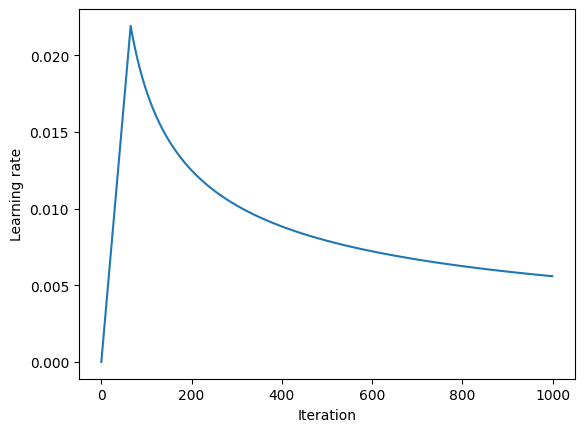

In [9]:
warmup_steps = 65
schedule = lambda x: (n_heads * d_q) ** -0.5 * jnp.minimum(
    x**-0.5, x * warmup_steps**-1.5
)
optimizer = optax.adam(schedule)
opt_state = optimizer.init(eqx.filter(transformer, eqx.is_array))

lrs = jax.vmap(schedule)(jnp.arange(1_000))

plt.plot(lrs)
plt.xlabel("Iteration")
plt.ylabel("Learning rate")
plt.show()

Now we have all the training functions. The important thing to remember here is that we need to mask the loss/accuracy, since not all of the array input is actually to be dealt with (this is handled internally in the transformer, which is why we aren't passing masks to it). The other thing to keep in mind is that we need to shift the input/output of the decoder part of the transformer.

In [10]:
def masked_loss(logits, labels):
    mask = labels != padding_token
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
    loss = loss * mask
    loss = jnp.sum(loss) / jnp.sum(mask)
    return loss


def masked_accuracy(logits, labels):
    preds = jnp.argmax(logits, axis=-1)
    match = (labels == preds).astype("int16")
    mask = (labels != padding_token).astype("int16")
    match = (mask & match).astype("float32")
    mask = mask.astype("float32")
    return jnp.sum(match) / jnp.sum(mask)


def model_loss(model, src, trg, labels, key):
    logits = model.enc_dec_call(src, trg, enable_dropout=True, key=key)
    return masked_loss(logits, labels), logits


def vmap_loss(model, src, trg, labels, key):
    loss, logits = eqx.filter_vmap(model_loss, in_axes=(None, 0, 0, 0, 0))(
        model, src, trg, labels, key
    )
    return jnp.mean(loss), logits


def concat(x, y):
    return jnp.concatenate((x, y), axis=0)


@eqx.filter_jit
def eval_model(model, inputs, key):
    src, trg = inputs[0], inputs[1]
    ins = jax.vmap(concat, in_axes=(0, None))(
        jnp.where(trg == ending_token, padding_token, trg)[:, :-1],
        jnp.array([padding_token]),
    )
    labels = jax.vmap(concat, in_axes=(0, None))(trg[:, 1:], jnp.array([padding_token]))
    keys = jax.random.split(key, len(src))

    loss, logits = vmap_loss(model, src, ins, labels, keys)

    accuracy = jnp.mean(eqx.filter_vmap(masked_accuracy)(logits, labels))

    return loss, accuracy


@eqx.filter_jit
def step(model, inputs, opt_state, key):
    src, trg = inputs[0], inputs[1]
    ins = jax.vmap(concat, in_axes=(0, None))(
        jnp.where(trg == ending_token, padding_token, trg)[:, :-1],
        jnp.array([padding_token]),
    )
    labels = jax.vmap(concat, in_axes=(0, None))(trg[:, 1:], jnp.array([padding_token]))
    keys = jax.random.split(key, batch_size)

    (loss, logits), grads = eqx.filter_value_and_grad(vmap_loss, has_aux=True)(
        model, src, ins, labels, keys
    )

    updates, opt_state = optimizer.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)

    accuracy = jnp.mean(eqx.filter_vmap(masked_accuracy)(logits, labels))

    return model, opt_state, loss, accuracy

Now let's train!

In [11]:
batch_size = 50
epochs = 1  # 100
losses = []
accs = []
val_losses = []
val_accs = []
total_batches = train_seq_in.shape[0] // batch_size
training_data = range(0, train_seq_in.shape[0], batch_size)


for e in range(epochs):  # tqdm(range(epochs)):
    inner_l = []
    inner_a = []
    for i in training_data:
        inputs = (train_seq_in[i : i + batch_size], train_seq_trg[i : i + batch_size])
        key, subkey = jax.random.split(key, 2)
        transformer, opt_state, loss, accuracy = step(
            transformer, inputs, opt_state, subkey
        )
        inner_l.append(loss)
        inner_a.append(accuracy)
    l, a = eval_model(transformer, (test_seq_in, test_seq_trg), key)
    val_losses.append(l)
    val_accs.append(a)
    losses.append(inner_l)
    accs.append(inner_a)

  0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
losses = jnp.array(losses)
accs = jnp.array(accs)

Plotting the accuracy and losses shows how well the transformer is doing on our simple task. 

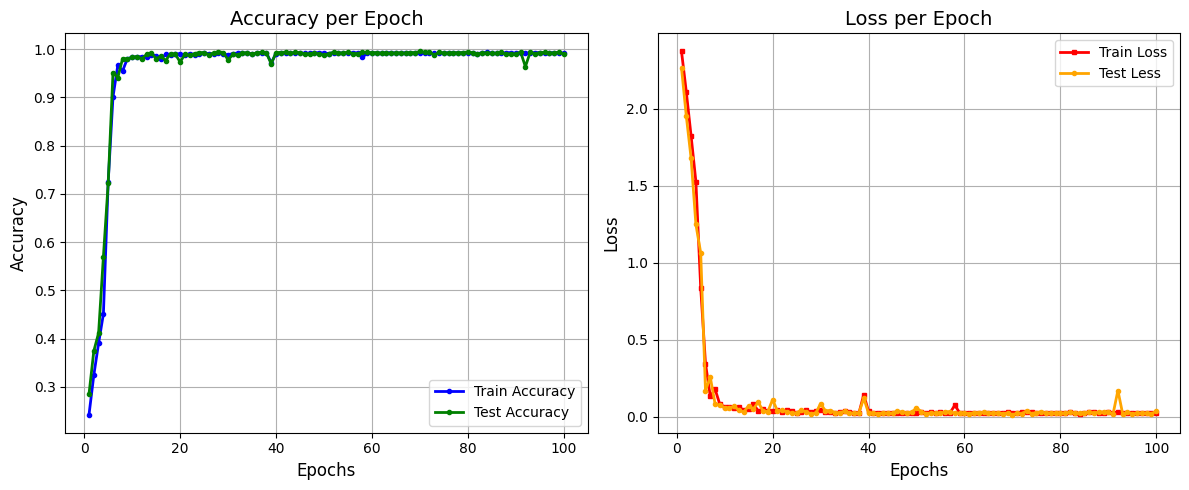

In [13]:
accs1 = jnp.mean(accs, axis=-1)
losses1 = jnp.mean(losses, axis=-1)

epochs = range(1, len(accs) + 1)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot accuracy per epoch
ax1.plot(
    epochs,
    accs1,
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=3,
    color="blue",
    label="Train Accuracy",
)
ax1.plot(
    epochs,
    val_accs,
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=3,
    color="green",
    label="Test Accuracy",
)
ax1.set_xlabel("Epochs", fontsize=12)
ax1.set_ylabel("Accuracy", fontsize=12)
ax1.set_title("Accuracy per Epoch", fontsize=14)
ax1.grid(True)
ax1.legend()

# Plot losses per epoch
ax2.plot(
    epochs,
    losses1,
    marker="s",
    linestyle="-",
    linewidth=2,
    markersize=3,
    color="red",
    label="Train Loss",
)
ax2.plot(
    epochs,
    val_losses,
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=3,
    color="orange",
    label="Test Less",
)
ax2.set_xlabel("Epochs", fontsize=12)
ax2.set_ylabel("Loss", fontsize=12)
ax2.set_title("Loss per Epoch", fontsize=14)
ax2.grid(True)
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()

To do "inference"/translation, we need to change the setup a little. We generate the whole output, but only take one token (the next one) at a time, then use that token and predict the next one based on that input (i.e. we infer autoregressively).

In [14]:
fwd = eqx.filter_jit(transformer.enc_dec_call)


def translate(inputs):
    encoder_input = inputs
    output_array = jnp.zeros(shape=(length,))  # padding token
    output_array = output_array.at[0].set(beginning_token)

    def body_fun(i, val):
        if ending_token in val:
            return val
        logits = fwd(encoder_input, val, enable_dropout=False)
        pred = jnp.argmax(logits, axis=-1)[i]
        return val.at[i + 1].set(pred)

    val = output_array
    for i in range(length - 1):
        val = body_fun(i, val)

    return val

Let's look at some simple examples.

In [15]:
nums = [5, 6, 7, 8]
tokenized = [beginning_token] + nums + [ending_token]
inputs = jnp.array(tokenized + [padding_token for _ in range(length - len(tokenized))])

rev = list(reversed(nums))
tokenized_rev = [beginning_token] + rev + [ending_token]
reved = jnp.array(
    tokenized_rev + [padding_token for _ in range(length - len(tokenized_rev))]
)

output = translate(inputs)

In [16]:
print("Inputs", inputs)
print("REVERSED:", rev)
print("Transformer:", output)

Inputs [1 5 6 7 8 2 0 0 0 0]
REVERSED: [8, 7, 6, 5]
Transformer: [1. 8. 7. 6. 5. 2. 0. 0. 0. 0.]


In [17]:
nums = [
    10,
    12,
    5,
    9,
    8,
    9,
]
tokenized = [beginning_token] + nums + [ending_token]
inputs = jnp.array(tokenized + [padding_token for _ in range(length - len(tokenized))])
output = translate(inputs)

In [18]:
print("Inputs", inputs)
print("REVERSED:", list(reversed(nums)))
print("Transformer:", output)

Inputs [ 1 10 12  5  9  8  9  2  0  0]
REVERSED: [9, 8, 9, 5, 12, 10]
Transformer: [ 1.  9.  8.  9.  5. 12. 10.  2.  0.  0.]
